# Kantelpunt Detectie - NDW Data Analyse


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
import sys
from pathlib import Path
# Pipeline importeren
current_dir = Path.cwd()
project_dir = current_dir.parent
sys.path.append(str(project_dir))
1
from Data_Preperatie.pipeline import prepare_data
# Laad data
df_raw = pd.read_csv("../data/kpgouda_vier_locaties/kpgouda_vier_locaties.csv",
low_memory=False
)
# Prepareer data
df = prepare_data(df_raw)

print(f"Totaal observaties: {len(df):,}")
print(f"Meetlocaties: {df['id_meetlocatie'].nunique()}")
print(f"Periode: {df['start_meetperiode'].min()} tot {df['start_meetperiode'].max()}")
print(f"\nKolommen: {df.columns.tolist()}")


Totaal observaties: 1,939,431
Meetlocaties: 4
Periode: 2023-11-13 00:00:00 tot 2025-11-20 23:55:00

Kolommen: ['id_meetlocatie', 'start_meetperiode', 'eind_meetperiode', 'ndw_index', 'gem_intensiteit', 'gem_snelheid', 'totaal_aantal_rijstroken', 'rijstrook_rijbaan', 'locatiecode_vild', 'specifieke_baan', 'datum', 'tijd', 'gem_snelheid_smooth', 'gem_intensiteit_smooth', 'wegtype', 'geometry']


## Data Filteren

We selecteren **lane1** (rechterrijstrook) omdat:
- Als lane1 vastloopt, staat de hele weg vast
- Het is de "indicator" rijstrook voor congestie

We kiezen ook **één locatie** om mee te beginnen, zodat we de patronen goed leren kennen voordat we generaliseren.

In [5]:
# Filter op lane1
df_lane1 = df[df['rijstrook_rijbaan'] == 'lane1'].copy()
df_lane1['datum'] = pd.to_datetime(df_lane1['start_meetperiode']).dt.date


df_lane1["naam"] = df_lane1["id_meetlocatie"]

print(df_lane1['naam'].unique())
print(f"\nTotaal observaties lane1: {len(df_lane1):,}")

# Kies eerste locatie
LOCATIE = df_lane1['naam'].unique()[0]
df_locatie = df_lane1[df_lane1['naam'] == LOCATIE].copy()

print(f"Locatie: {LOCATIE}")
print(f"Observaties: {len(df_locatie):,}")
print(f"Aantal dagen: {df_locatie['datum'].nunique()}")

['RWS01_MONIBAS_0121hrr0240ra' 'RWS01_MONIBAS_0121hrr0275ra'
 'RWS01_MONIBAS_0121hrr0288ra' 'RWS01_MONIBAS_0201hrr0475ra']

Totaal observaties lane1: 496,865
Locatie: RWS01_MONIBAS_0121hrr0240ra
Observaties: 118,184
Aantal dagen: 699


## Willekeurige dagen bekijken

Om een goede kantelpunt-definitie te maken, moeten we eerst begrijpen hoe congestie eruitziet. We bekijken willekeurige dagen en letten op:

- **Normale dag:** Snelheid blijft stabiel rond 100-120 km/u
- **Congestie dag:** Snelheid zakt (tijdelijk) fors naar beneden

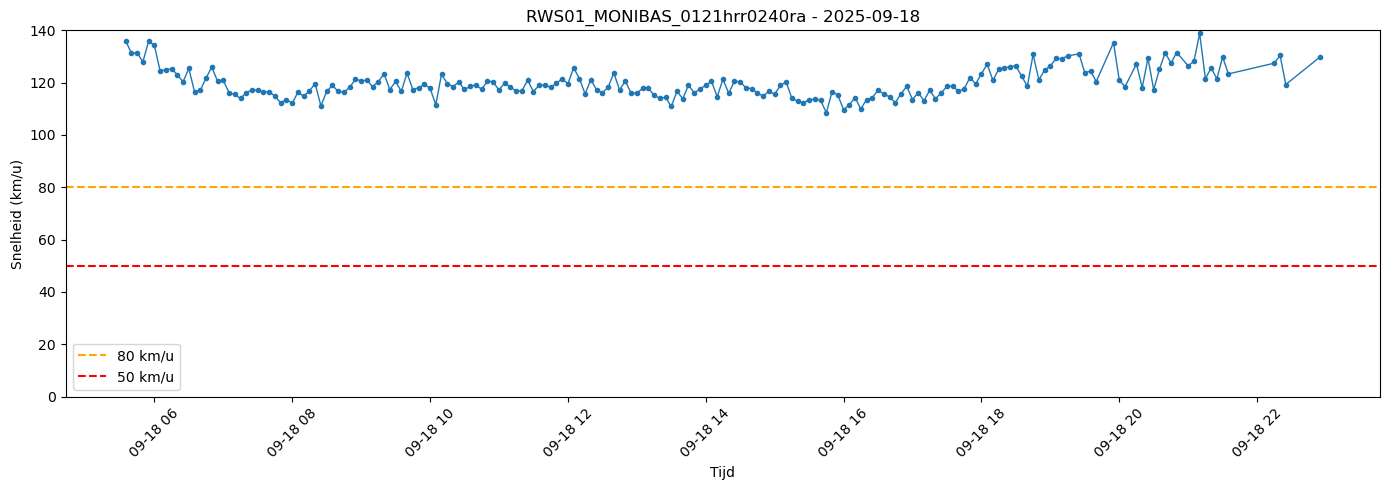

Datum: 2025-09-18
Min: 109 km/u | Max: 139 km/u | Gem: 120 km/u


In [6]:
# Willekeurige dag selecteren
random_datum = df_locatie['datum'].drop_duplicates().sample(1).values[0]
dag_data = df_locatie[df_locatie['datum'] == random_datum].sort_values('start_meetperiode')

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(dag_data['start_meetperiode'], dag_data['gem_snelheid'], 
        marker='o', markersize=3, linewidth=1)
ax.axhline(y=80, color='orange', linestyle='--', label='80 km/u')
ax.axhline(y=50, color='red', linestyle='--', label='50 km/u')
ax.set_xlabel('Tijd')
ax.set_ylabel('Snelheid (km/u)')
ax.set_title(f'{LOCATIE} - {random_datum}')
ax.legend()
ax.set_ylim(0, 140)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistieken
print(f"Datum: {random_datum}")
print(f"Min: {dag_data['gem_snelheid'].min():.0f} km/u | "
      f"Max: {dag_data['gem_snelheid'].max():.0f} km/u | "
      f"Gem: {dag_data['gem_snelheid'].mean():.0f} km/u")

## Inzoomen op Congestie-moment

We pakken de dag met congestie (2024-05-16) en zoomen in op het moment van de snelheidsdaling. We willen weten:

1. **Hoeveel tijdstappen** duurt de daling? (elke stap = 5 minuten)
2. **Met hoeveel km/u** daalt de snelheid per stap?

Dit geeft ons de parameters voor onze kantelpunt-definitie.

In [7]:
# Selecteer de congestie-dag
congestie_datum = pd.to_datetime('2024-05-16').date()
dag_data = df_locatie[df_locatie['datum'] == congestie_datum].sort_values('start_meetperiode')

# Bereken snelheidsverandering per tijdstap
dag_data = dag_data.copy()
dag_data['snelheid_diff'] = dag_data['gem_snelheid'].diff()
dag_data['tijd_str'] = pd.to_datetime(dag_data['start_meetperiode']).dt.strftime('%H:%M')

# Zoom in op ochtend (06:00 - 10:00)
dag_data['uur'] = pd.to_datetime(dag_data['start_meetperiode']).dt.hour
zoom = dag_data[(dag_data['uur'] >= 6) & (dag_data['uur'] <= 10)].copy()

# Toon de data rond het kantelpunt
print("Snelheidsverloop 06:00 - 10:00:\n")
print(zoom[['tijd_str', 'gem_snelheid', 'snelheid_diff']].to_string(index=False))

Snelheidsverloop 06:00 - 10:00:

tijd_str  gem_snelheid  snelheid_diff
   06:00        126.42           3.13
   06:05        122.78          -3.64
   06:10        119.93          -2.85
   06:15        121.33           1.40
   06:20        120.71          -0.62
   06:25        117.57          -3.14
   06:30        120.98           3.41
   06:35        122.13           1.15
   06:40        121.13          -1.00
   06:45        119.09          -2.04
   06:50        116.56          -2.53
   06:55        116.12          -0.44
   07:00        115.27          -0.85
   07:05        115.64           0.37
   07:10        115.50          -0.14
   07:15        113.54          -1.96
   07:20        106.64          -6.90
   07:25         99.90          -6.74
   07:30         73.71         -26.19
   07:35         63.56         -10.15
   07:40         35.67         -27.89
   07:45         39.60           3.93
   07:50         55.24          15.64
   07:55         44.42         -10.82
   08:00         

## Visualisatie Kantelpunt-moment

We visualiseren het exacte moment van de snelheidsdaling om het patroon duidelijk te zien:
- **Bovenste grafiek:** Snelheid over tijd
- **Onderste grafiek:** Snelheidsverandering per 5 minuten (negatief = daling)

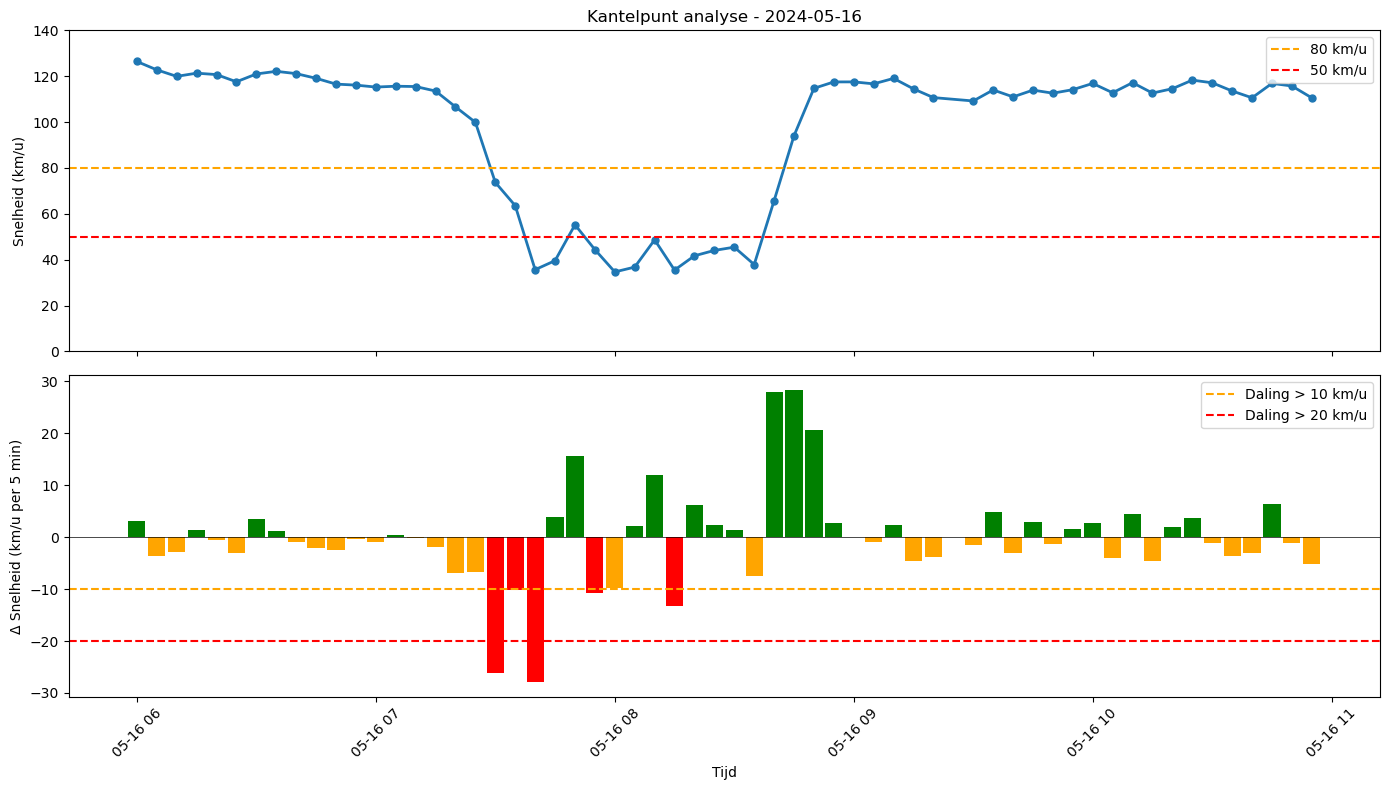

In [8]:
# Visualisatie van het kantelpunt
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Snelheid
ax1 = axes[0]
ax1.plot(zoom['start_meetperiode'], zoom['gem_snelheid'], 
         marker='o', markersize=5, linewidth=2)
ax1.axhline(y=80, color='orange', linestyle='--', label='80 km/u')
ax1.axhline(y=50, color='red', linestyle='--', label='50 km/u')
ax1.set_ylabel('Snelheid (km/u)')
ax1.set_title(f'Kantelpunt analyse - {congestie_datum}')
ax1.legend()
ax1.set_ylim(0, 140)

# Snelheidsverandering
ax2 = axes[1]
colors = ['red' if x < -10 else 'orange' if x < 0 else 'green' 
          for x in zoom['snelheid_diff'].fillna(0)]
ax2.bar(zoom['start_meetperiode'], zoom['snelheid_diff'].fillna(0), 
        color=colors, width=0.003)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axhline(y=-10, color='orange', linestyle='--', label='Daling > 10 km/u')
ax2.axhline(y=-20, color='red', linestyle='--', label='Daling > 20 km/u')
ax2.set_ylabel('Δ Snelheid (km/u per 5 min)')
ax2.set_xlabel('Tijd')
ax2.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Meerdere Congestie-events Analyseren

Een voorbeeld is niet genoeg om een definitie op te baseren. We zoeken alle dagen met significante congestie (snelheid < 50 km/u) en analyseren het patroon:

- Hoeveel stappen duurt de daling gemiddeld?
- Hoe groot zijn de dalingen?
- Is er een consistent patroon?

In [9]:
# Vind alle dagen met congestie (min snelheid < 50 km/u)
dag_stats = df_locatie.groupby('datum').agg({
    'gem_snelheid': ['min', 'max', 'mean']
}).reset_index()
dag_stats.columns = ['datum', 'min_snelheid', 'max_snelheid', 'gem_snelheid']

congestie_dagen = dag_stats[dag_stats['min_snelheid'] < 50].sort_values('min_snelheid')

print(f"Totaal dagen: {len(dag_stats)}")
print(f"Dagen met congestie (min < 50 km/u): {len(congestie_dagen)}")
print(f"\nTop 10 ergste congestie-dagen:")
print(congestie_dagen.head(10).to_string(index=False))

Totaal dagen: 699
Dagen met congestie (min < 50 km/u): 111

Top 10 ergste congestie-dagen:
     datum  min_snelheid  max_snelheid  gem_snelheid
2025-10-06          4.76        136.74    113.283787
2025-03-13          4.80        134.37    111.636686
2025-04-30          5.73        144.88    111.228073
2024-10-22          5.99        140.74    107.478045
2025-05-13          6.06        138.11    106.180543
2024-12-09          6.06        134.05    106.352824
2025-10-01          6.07        138.67    110.518634
2025-09-09          7.18        132.53    112.894134
2025-03-05          7.33        142.95    115.736033
2025-03-27          7.74        142.32    114.260960


## Patroon van Snelheidsdaling Analyseren

We analyseren hoe de snelheid daalt in de aanloop naar congestie:
- We zoeken het moment dat de snelheid onder 50 km/u komt
- We bekijken de 6 tijdstappen (30 minuten) **ervoor**
- We meten de snelheidsverandering per stap

In [10]:
# Analyseer de daling voor elk congestie-moment
df_sorted = df_locatie.sort_values('start_meetperiode').reset_index(drop=True)
df_sorted['snelheid_diff'] = df_sorted['gem_snelheid'].diff()

# Vind momenten waar snelheid onder 50 komt
df_sorted['onder_50'] = df_sorted['gem_snelheid'] < 50
df_sorted['vorige_boven_80'] = df_sorted['gem_snelheid'].shift(1) > 80
df_sorted['congestie_start'] = df_sorted['onder_50'] & df_sorted['vorige_boven_80']

congestie_starts = df_sorted[df_sorted['congestie_start']].index.tolist()
print(f"Aantal congestie-start momenten gevonden: {len(congestie_starts)}")

# Verzamel de 6 stappen voor elk congestie-moment
dalingen_voor_congestie = []

for idx in congestie_starts:
    if idx >= 6:  # We hebben 6 voorgaande stappen nodig
        window = df_sorted.loc[idx-6:idx, ['gem_snelheid', 'snelheid_diff']].copy()
        if len(window) == 7:
            dalingen_voor_congestie.append({
                'stap_min6': window.iloc[0]['snelheid_diff'],
                'stap_min5': window.iloc[1]['snelheid_diff'],
                'stap_min4': window.iloc[2]['snelheid_diff'],
                'stap_min3': window.iloc[3]['snelheid_diff'],
                'stap_min2': window.iloc[4]['snelheid_diff'],
                'stap_min1': window.iloc[5]['snelheid_diff'],
                'stap_0': window.iloc[6]['snelheid_diff'],
                'snelheid_min6': window.iloc[0]['gem_snelheid'],
                'snelheid_0': window.iloc[6]['gem_snelheid'],
            })

df_dalingen = pd.DataFrame(dalingen_voor_congestie)
print(f"Geanalyseerde events: {len(df_dalingen)}")
print(f"\nGemiddelde snelheidsverandering per stap (in km/u):\n")
print(df_dalingen[['stap_min6', 'stap_min5', 'stap_min4', 'stap_min3', 
                   'stap_min2', 'stap_min1', 'stap_0']].mean().round(1))

Aantal congestie-start momenten gevonden: 59
Geanalyseerde events: 59

Gemiddelde snelheidsverandering per stap (in km/u):

stap_min6    -0.1
stap_min5     2.2
stap_min4     3.2
stap_min3    -0.6
stap_min2    -0.7
stap_min1   -12.1
stap_0      -61.7
dtype: float64


## Visualisatie Dalingspatroon

We visualiseren het gemiddelde patroon en de spreiding om te zien hoe consistent dit is.

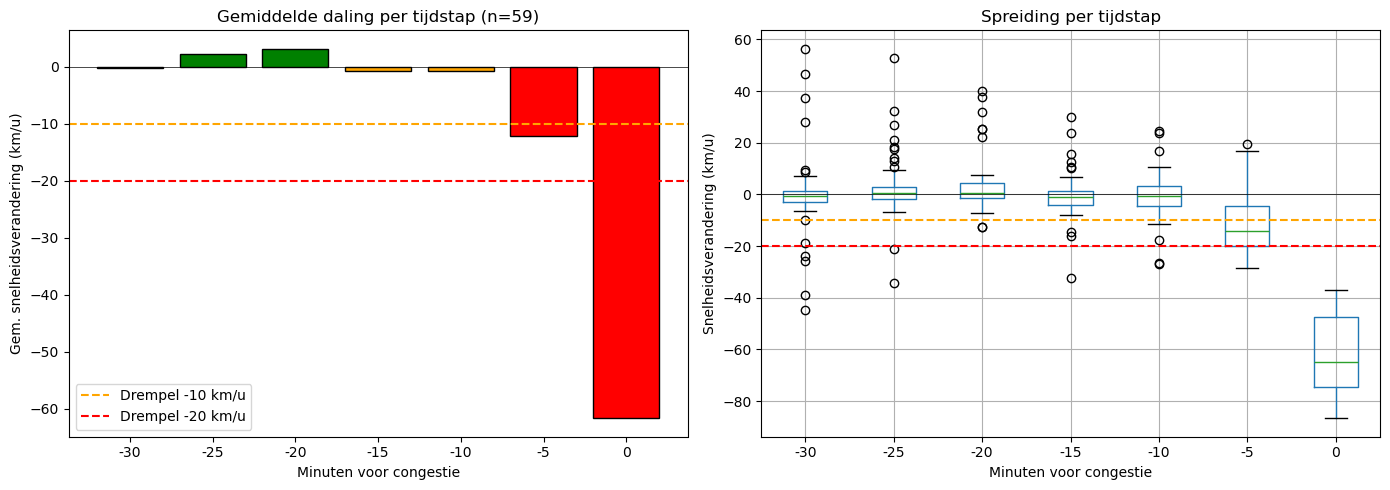

Statistieken stap -1 (5 min voor congestie):
count    59.0
mean    -12.1
std      10.8
min     -28.4
25%     -20.0
50%     -14.1
75%      -4.7
max      19.6
Name: stap_min1, dtype: float64

Statistieken stap 0 (congestie-moment):
count    59.0
mean    -61.7
std      14.8
min     -86.6
25%     -74.6
50%     -64.7
75%     -47.4
max     -37.0
Name: stap_0, dtype: float64


In [11]:
# Visualiseer het gemiddelde dalingspatroon
stappen = ['stap_min6', 'stap_min5', 'stap_min4', 'stap_min3', 
           'stap_min2', 'stap_min1', 'stap_0']
x_labels = ['-30', '-25', '-20', '-15', '-10', '-5', '0']

gemiddelde = df_dalingen[stappen].mean()
std = df_dalingen[stappen].std()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gemiddelde daling per stap
ax1 = axes[0]
colors = ['red' if v < -10 else 'orange' if v < 0 else 'green' for v in gemiddelde]
ax1.bar(x_labels, gemiddelde, color=colors, edgecolor='black')
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.axhline(y=-10, color='orange', linestyle='--', label='Drempel -10 km/u')
ax1.axhline(y=-20, color='red', linestyle='--', label='Drempel -20 km/u')
ax1.set_xlabel('Minuten voor congestie')
ax1.set_ylabel('Gem. snelheidsverandering (km/u)')
ax1.set_title('Gemiddelde daling per tijdstap (n=59)')
ax1.legend()

# Boxplot van de spreiding
ax2 = axes[1]
df_dalingen[stappen].boxplot(ax=ax2)
ax2.set_xticklabels(x_labels)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axhline(y=-10, color='orange', linestyle='--')
ax2.axhline(y=-20, color='red', linestyle='--')
ax2.set_xlabel('Minuten voor congestie')
ax2.set_ylabel('Snelheidsverandering (km/u)')
ax2.set_title('Spreiding per tijdstap')

plt.tight_layout()
plt.show()

# Statistieken van de cruciale stappen
print("Statistieken stap -1 (5 min voor congestie):")
print(df_dalingen['stap_min1'].describe().round(1))
print("\nStatistieken stap 0 (congestie-moment):")
print(df_dalingen['stap_0'].describe().round(1))

## Kantelpunt Definitie Formuleren

Op basis van onze analyse kunnen we nu de definitie opstellen voor de target variabele.

### Bevindingen uit de analyse:

| Aspect | Bevinding |
|--------|-----------|
| Aantal events geanalyseerd | 59 congestie-momenten |
| Patroon | Congestie ontstaat zeer plotseling |
| Tijdsduur daling | 1-2 stappen (5-10 minuten) |
| Daling stap -1 | Gemiddeld -12 km/u (mediaan -14 km/u) |
| Daling stap 0 | Gemiddeld -62 km/u (mediaan -65 km/u) |

### Voorgestelde Kantelpunt Definitie:

**Een kantelpunt treedt op wanneer:**

> De snelheid daalt met **meer dan 20 km/u** binnen **2 opeenvolgende tijdstappen** (10 minuten)

**OF**

> De snelheid komt onder de **50 km/u** terwijl de vorige meting boven **80 km/u** was

### Als target variabele:
- **0** = Geen kantelpunt (normale doorstroming)
- **1** = Kantelpunt (congestie begint)

In [12]:
# Implementeer de kantelpunt definitie
def bepaal_kantelpunt(df, snelheid_col='gem_snelheid'):
    """
    Bepaal kantelpunt op basis van:
    - Daling > 20 km/u in 2 opeenvolgende stappen, OF
    - Snelheid < 50 km/u terwijl vorige meting > 80 km/u
    """
    df = df.sort_values('start_meetperiode').copy()
    
    # Bereken dalingen
    df['daling_1_stap'] = df[snelheid_col].diff()
    df['daling_2_stappen'] = df[snelheid_col].diff(periods=2)
    
    # Vorige snelheid
    df['vorige_snelheid'] = df[snelheid_col].shift(1)
    
    # Kantelpunt criteria
    criterium_1 = df['daling_2_stappen'] < -20  # >20 km/u daling in 2 stappen
    criterium_2 = (df[snelheid_col] < 50) & (df['vorige_snelheid'] > 80)  # Plotselinge val
    
    df['kantelpunt'] = (criterium_1 | criterium_2).astype(int)
    
    return df

# Pas toe op de data
df_result = bepaal_kantelpunt(df_locatie)

# Resultaten
print(f"Totaal observaties: {len(df_result):,}")
print(f"Kantelpunten gedetecteerd: {df_result['kantelpunt'].sum():,}")
print(f"Percentage: {df_result['kantelpunt'].mean()*100:.2f}%")

# Per dag
df_result['datum'] = pd.to_datetime(df_result['start_meetperiode']).dt.date
dagen_met_kantelpunt = df_result.groupby('datum')['kantelpunt'].max().sum()
print(f"\nDagen met minstens 1 kantelpunt: {dagen_met_kantelpunt} van {df_result['datum'].nunique()}")


Totaal observaties: 118,184
Kantelpunten gedetecteerd: 805
Percentage: 0.68%

Dagen met minstens 1 kantelpunt: 278 van 699


## Validatie van de Definitie

We visualiseren een paar dagen met gedetecteerde kantelpunten om te controleren of de definitie correct werkt. De rode punten zijn de gedetecteerde kantelpunten.

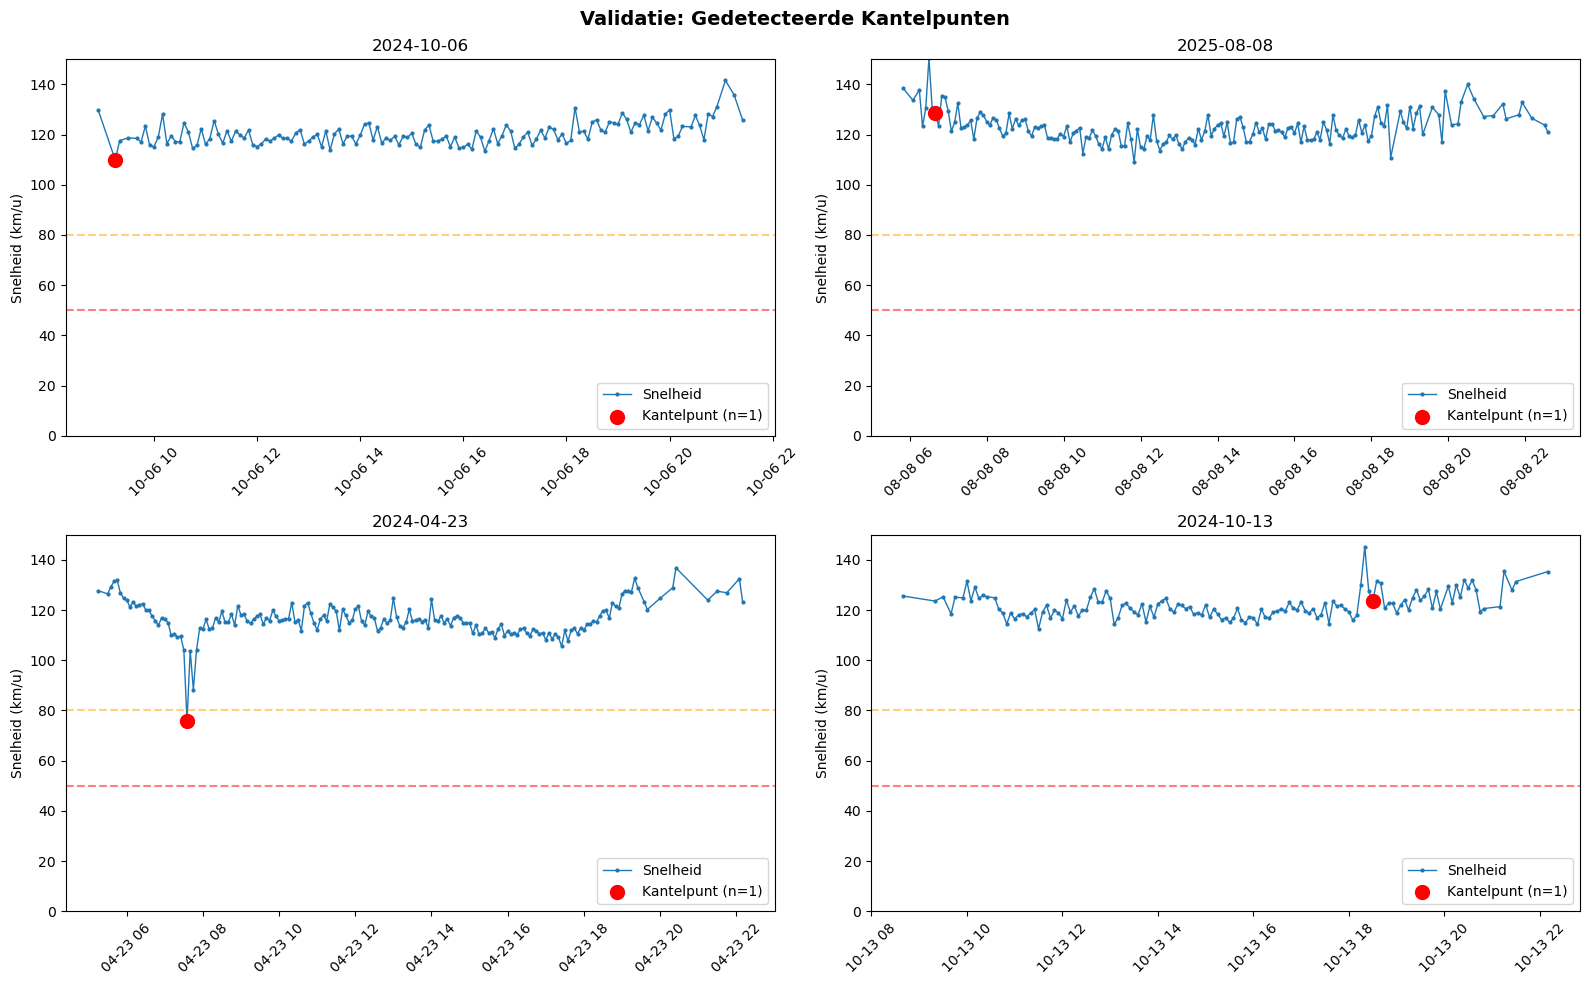

In [13]:
import numpy as np
# Selecteer 4 willekeurige dagen met kantelpunten
dagen_met_kp = df_result[df_result['kantelpunt'] == 1]['datum'].unique()
sample_dagen = np.random.choice(dagen_met_kp, size=min(4, len(dagen_met_kp)), replace=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, datum in enumerate(sample_dagen):
    dag_data = df_result[df_result['datum'] == datum].sort_values('start_meetperiode')
    ax = axes[idx]
    
    # Plot snelheid
    ax.plot(dag_data['start_meetperiode'], dag_data['gem_snelheid'], 
            marker='o', markersize=2, linewidth=1, label='Snelheid')
    
    # Markeer kantelpunten
    kp = dag_data[dag_data['kantelpunt'] == 1]
    ax.scatter(kp['start_meetperiode'], kp['gem_snelheid'], 
               color='red', s=100, zorder=5, label=f'Kantelpunt (n={len(kp)})')
    
    ax.axhline(y=80, color='orange', linestyle='--', alpha=0.5)
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.5)
    ax.set_ylabel('Snelheid (km/u)')
    ax.set_title(f'{datum}')
    ax.legend(loc='lower right')
    ax.set_ylim(0, 150)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Validatie: Gedetecteerde Kantelpunten', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Definitie Aanscherpen

De huidige definitie geeft false positives bij kleine schommelingen. We voegen een extra criterium toe:

**Aangepaste definitie:**
Een kantelpunt treedt op wanneer:
1. De snelheid daalt met >20 km/u in 2 stappen, **EN**
2. De snelheid komt onder de **80 km/u**

In [14]:
# Aangescherpte kantelpunt definitie
def bepaal_kantelpunt_v2(df, snelheid_col='gem_snelheid'):
    """
    Aangescherpte kantelpunt definitie:
    - Daling > 20 km/u in 2 stappen, EN
    - Snelheid komt onder 80 km/u
    """
    df = df.sort_values('start_meetperiode').copy()
    
    # Bereken dalingen
    df['daling_2_stappen'] = df[snelheid_col].diff(periods=2)
    
    # Kantelpunt: grote daling EN snelheid onder 80
    df['kantelpunt'] = (
        (df['daling_2_stappen'] < -20) & 
        (df[snelheid_col] < 80)
    ).astype(int)
    
    return df

# Pas toe
df_result_v2 = bepaal_kantelpunt_v2(df_locatie)
df_result_v2['datum'] = pd.to_datetime(df_result_v2['start_meetperiode']).dt.date

# Vergelijk
print("Oude definitie (v1):")
print(f"  Kantelpunten: {df_result['kantelpunt'].sum():,}")
print(f"  Dagen met kantelpunt: {df_result.groupby('datum')['kantelpunt'].max().sum()}")

print("\nNieuwe definitie (v2):")
print(f"  Kantelpunten: {df_result_v2['kantelpunt'].sum():,}")
print(f"  Dagen met kantelpunt: {df_result_v2.groupby('datum')['kantelpunt'].max().sum()}")

Oude definitie (v1):
  Kantelpunten: 805
  Dagen met kantelpunt: 278

Nieuwe definitie (v2):
  Kantelpunten: 531
  Dagen met kantelpunt: 157


## Validatie Nieuwe Definitie

We controleren of de aangescherpte definitie correct werkt:
- Detecteert het echte congestie?
- Zijn de false positives weg?

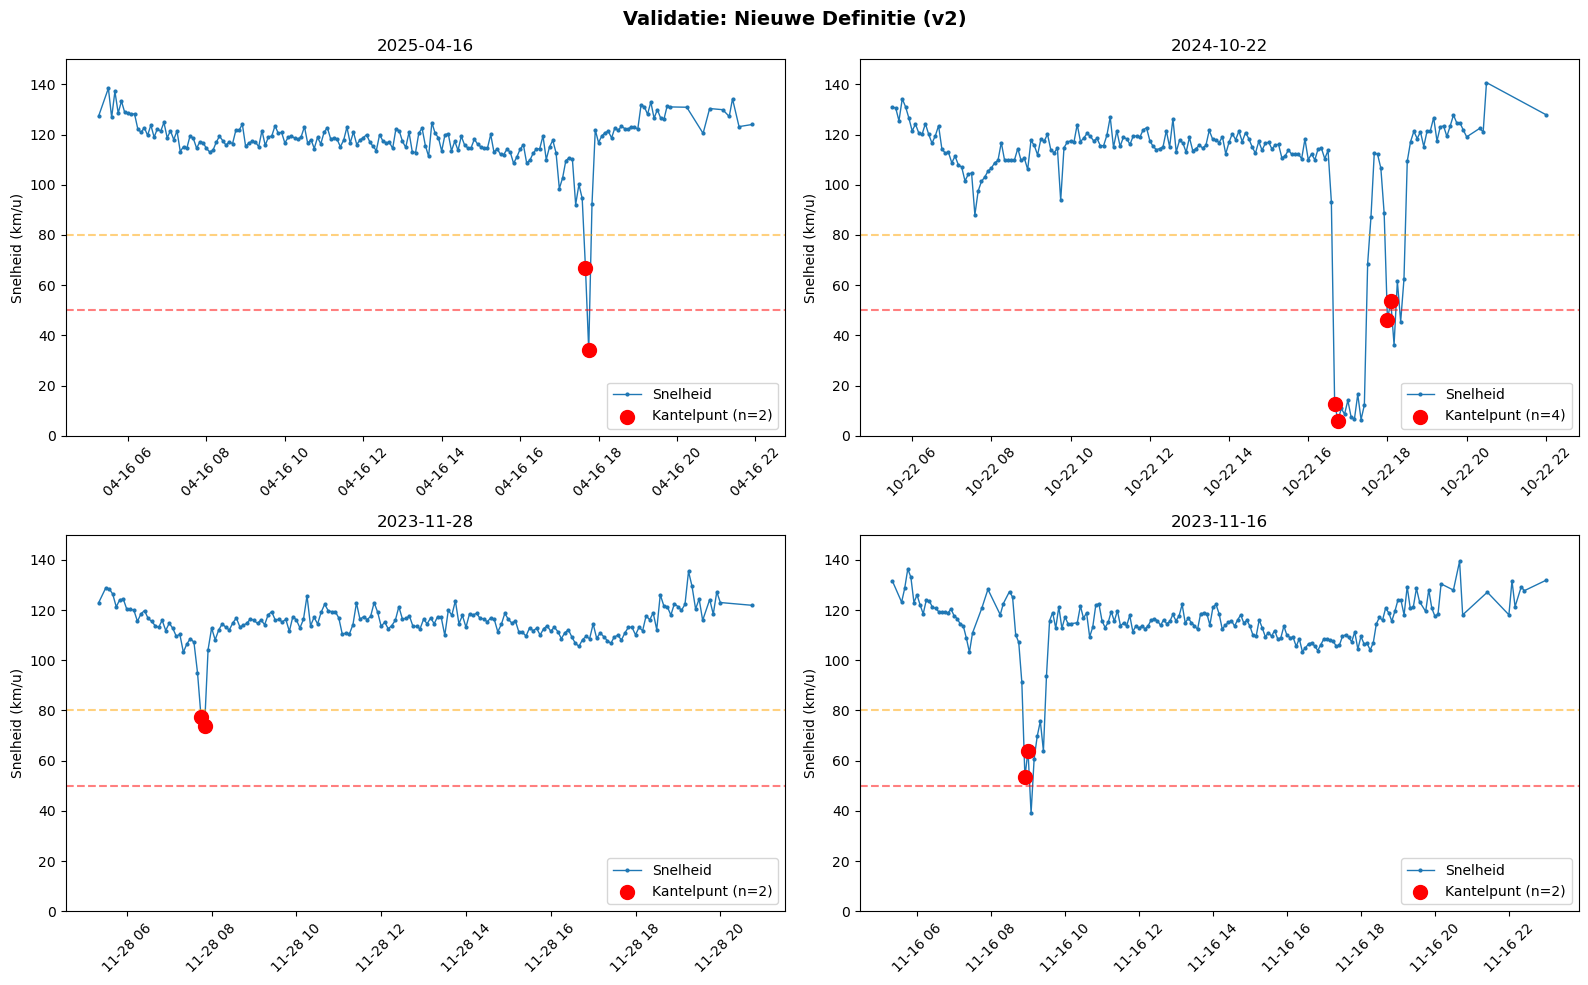

In [15]:
# Validatie nieuwe definitie
dagen_met_kp = df_result_v2[df_result_v2['kantelpunt'] == 1]['datum'].unique()
sample_dagen = np.random.choice(dagen_met_kp, size=min(4, len(dagen_met_kp)), replace=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, datum in enumerate(sample_dagen):
    dag_data = df_result_v2[df_result_v2['datum'] == datum].sort_values('start_meetperiode')
    ax = axes[idx]
    
    # Plot snelheid
    ax.plot(dag_data['start_meetperiode'], dag_data['gem_snelheid'], 
            marker='o', markersize=2, linewidth=1, label='Snelheid')
    
    # Markeer kantelpunten
    kp = dag_data[dag_data['kantelpunt'] == 1]
    ax.scatter(kp['start_meetperiode'], kp['gem_snelheid'], 
               color='red', s=100, zorder=5, label=f'Kantelpunt (n={len(kp)})')
    
    ax.axhline(y=80, color='orange', linestyle='--', alpha=0.5)
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.5)
    ax.set_ylabel('Snelheid (km/u)')
    ax.set_title(f'{datum}')
    ax.legend(loc='lower right')
    ax.set_ylim(0, 150)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Validatie: Nieuwe Definitie (v2)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

##  Definitie met 3 Tijdstappen

We verfijnen de definitie verder:

**Kantelpunt definitie v3:**
Een kantelpunt treedt op wanneer:
1. De snelheid **3 stappen geleden** boven 100 km/u was (normale doorstroming)
2. De snelheid **nu** onder 80 km/u is (congestie)

Dit betekent een daling van minstens 20 km/u over 15 minuten, vanuit een normale situatie.

In [16]:
# Kantelpunt definitie v3: daling over 3 stappen vanaf hoge snelheid
def bepaal_kantelpunt_v3(df, snelheid_col='gem_snelheid'):
    """
    Kantelpunt definitie v3:
    - 3 stappen geleden: snelheid > 100 km/u (vrije doorstroming)
    - Nu: snelheid < 80 km/u (congestie)
    """
    df = df.sort_values('start_meetperiode').copy()
    
    # Snelheid 3 stappen geleden
    df['snelheid_3_terug'] = df[snelheid_col].shift(3)
    
    # Kantelpunt: was hoog, nu laag
    df['kantelpunt'] = (
        (df['snelheid_3_terug'] > 100) & 
        (df[snelheid_col] < 80)
    ).astype(int)
    
    return df

# Pas toe
df_result_v3 = bepaal_kantelpunt_v3(df_locatie)
df_result_v3['datum'] = pd.to_datetime(df_result_v3['start_meetperiode']).dt.date

# Vergelijk alle versies
print("v1 (daling >20 in 2 stappen OF plotseling <50):")
print(f"   Kantelpunten: {df_result['kantelpunt'].sum():,} | Dagen: {df_result.groupby('datum')['kantelpunt'].max().sum()}")

print("\nv2 (daling >20 in 2 stappen EN <80):")
print(f"   Kantelpunten: {df_result_v2['kantelpunt'].sum():,} | Dagen: {df_result_v2.groupby('datum')['kantelpunt'].max().sum()}")

print("\nv3 (van >100 naar <80 in 3 stappen):")
print(f"   Kantelpunten: {df_result_v3['kantelpunt'].sum():,} | Dagen: {df_result_v3.groupby('datum')['kantelpunt'].max().sum()}")

v1 (daling >20 in 2 stappen OF plotseling <50):
   Kantelpunten: 805 | Dagen: 278

v2 (daling >20 in 2 stappen EN <80):
   Kantelpunten: 531 | Dagen: 157

v3 (van >100 naar <80 in 3 stappen):
   Kantelpunten: 412 | Dagen: 157


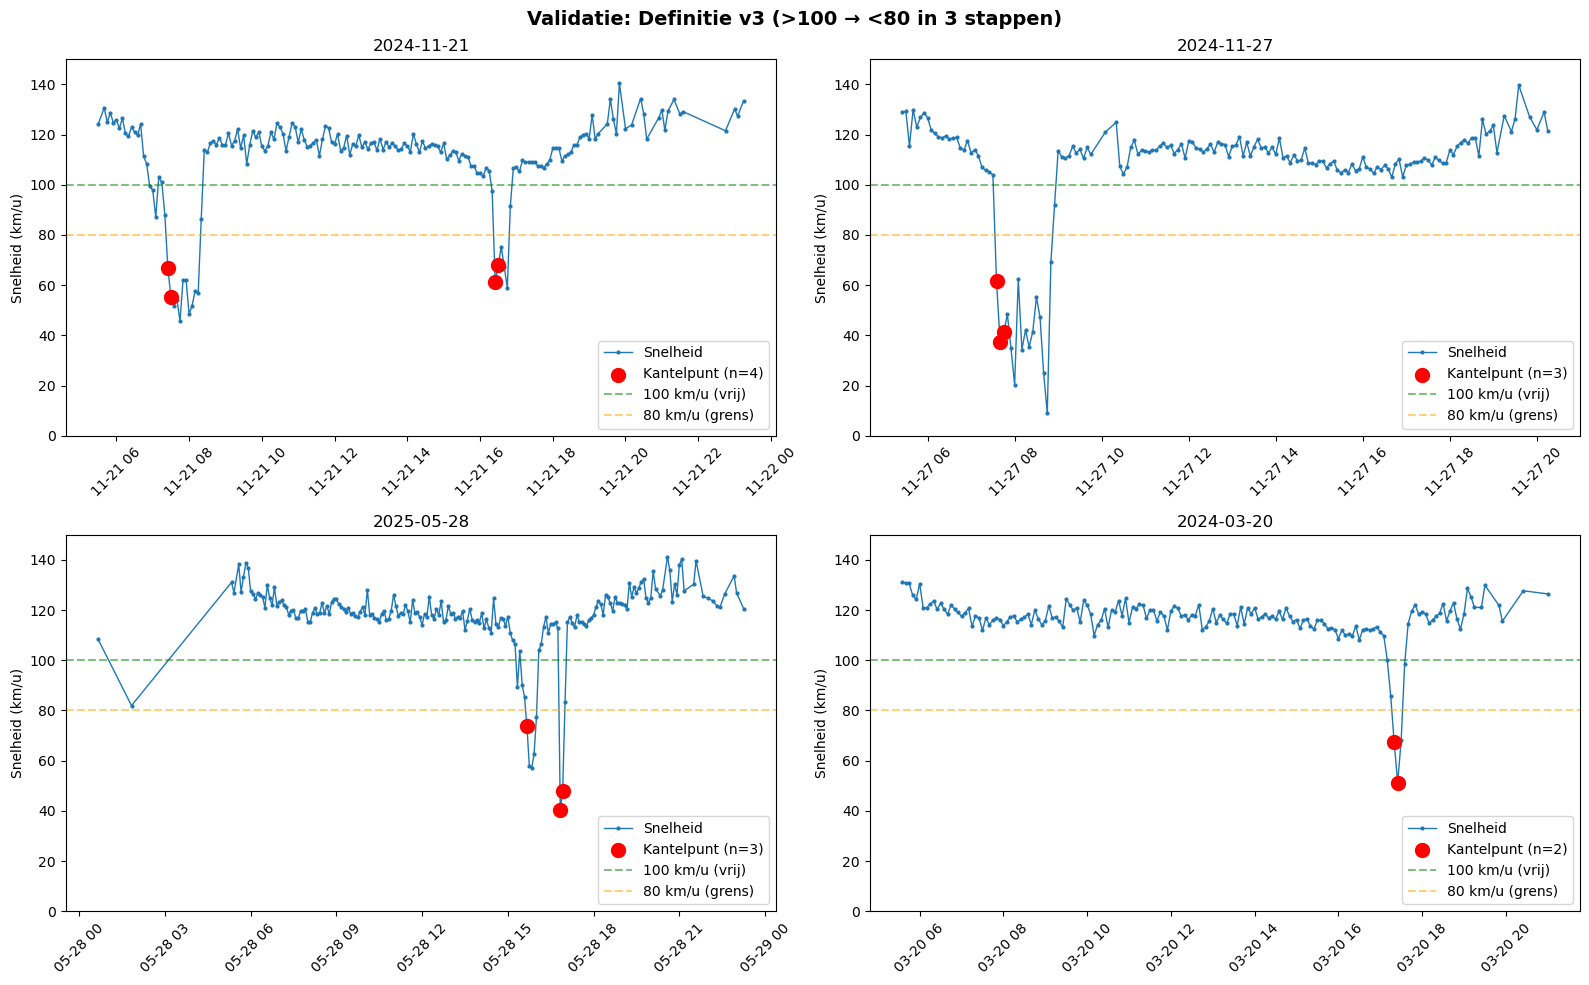

In [17]:
# Validatie v3
dagen_met_kp = df_result_v3[df_result_v3['kantelpunt'] == 1]['datum'].unique()
sample_dagen = np.random.choice(dagen_met_kp, size=min(4, len(dagen_met_kp)), replace=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, datum in enumerate(sample_dagen):
    dag_data = df_result_v3[df_result_v3['datum'] == datum].sort_values('start_meetperiode')
    ax = axes[idx]
    
    # Plot snelheid
    ax.plot(dag_data['start_meetperiode'], dag_data['gem_snelheid'], 
            marker='o', markersize=2, linewidth=1, label='Snelheid')
    
    # Markeer kantelpunten
    kp = dag_data[dag_data['kantelpunt'] == 1]
    ax.scatter(kp['start_meetperiode'], kp['gem_snelheid'], 
               color='red', s=100, zorder=5, label=f'Kantelpunt (n={len(kp)})')
    
    ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='100 km/u (vrij)')
    ax.axhline(y=80, color='orange', linestyle='--', alpha=0.5, label='80 km/u (grens)')
    ax.set_ylabel('Snelheid (km/u)')
    ax.set_title(f'{datum}')
    ax.legend(loc='lower right')
    ax.set_ylim(0, 150)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Validatie: Definitie v3 (>100 → <80 in 3 stappen)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Kantelpunt via met polyfit

In plaats van absolute drempels, berekenen we de **helling** van de snelheid over een rolling window.

**Aanpak:**
1. Neem een window van 4 metingen (20 minuten)
2. Fit een lineaire lijn (polyfit graad 1)
3. De helling geeft aan hoe snel de snelheid daalt (km/u per 5 min)

**Voordeel voor voorspelling:**
- Een sterke negatieve helling terwijl snelheid nog hoog is = vroeg waarschuwingssignaal
- We detecteren het kantelpunt **voordat** de file echt begint

Verdeling van hellingen (km/u per 5 min stap):

count    118181.00
mean         -0.00
std           2.66
min         -40.38
25%          -1.00
50%          -0.03
75%           0.97
max          41.89
Name: helling, dtype: float64


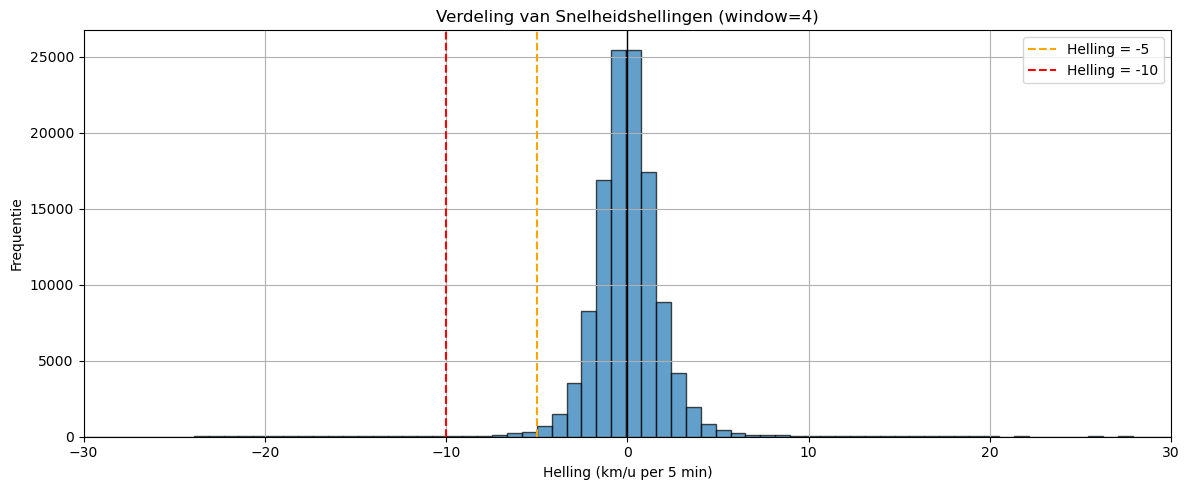

In [18]:
# Bereken helling via polyfit over rolling window
def bereken_helling(snelheden):
    """Bereken helling van snelheid via lineaire fit."""
    if len(snelheden) < 2 or snelheden.isna().any():
        return np.nan
    x = np.arange(len(snelheden))
    try:
        coef = np.polyfit(x, snelheden, 1)
        return coef[0]  # Helling (km/u per tijdstap)
    except:
        return np.nan

# Pas toe op de data
df_trend = df_locatie.sort_values('start_meetperiode').copy()

# Rolling window van 4 metingen (20 minuten)
df_trend['helling'] = df_trend['gem_snelheid'].rolling(window=4).apply(bereken_helling, raw=False)

# Bekijk de verdeling van hellingen
print("Verdeling van hellingen (km/u per 5 min stap):\n")
print(df_trend['helling'].describe().round(2))

# Histogram
fig, ax = plt.subplots(figsize=(12, 5))
df_trend['helling'].hist(bins=100, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='black', linewidth=1)
ax.axvline(x=-5, color='orange', linestyle='--', label='Helling = -5')
ax.axvline(x=-10, color='red', linestyle='--', label='Helling = -10')
ax.set_xlabel('Helling (km/u per 5 min)')
ax.set_ylabel('Frequentie')
ax.set_title('Verdeling van Snelheidshellingen (window=4)')
ax.legend()
ax.set_xlim(-30, 30)
plt.tight_layout()
plt.show()

## Helling als waarschuwingssignaal

We onderzoeken: als we een sterke negatieve helling detecteren terwijl de snelheid nog normaal is (>80 km/u), hoeveel tijd hebben we dan voordat de echte file begint?

Dit is cruciaal voor voorspelling: we willen het kantelpunt detecteren **voordat** het te laat is.

Kantelpunten (helling < -10, snelheid > 80): 57


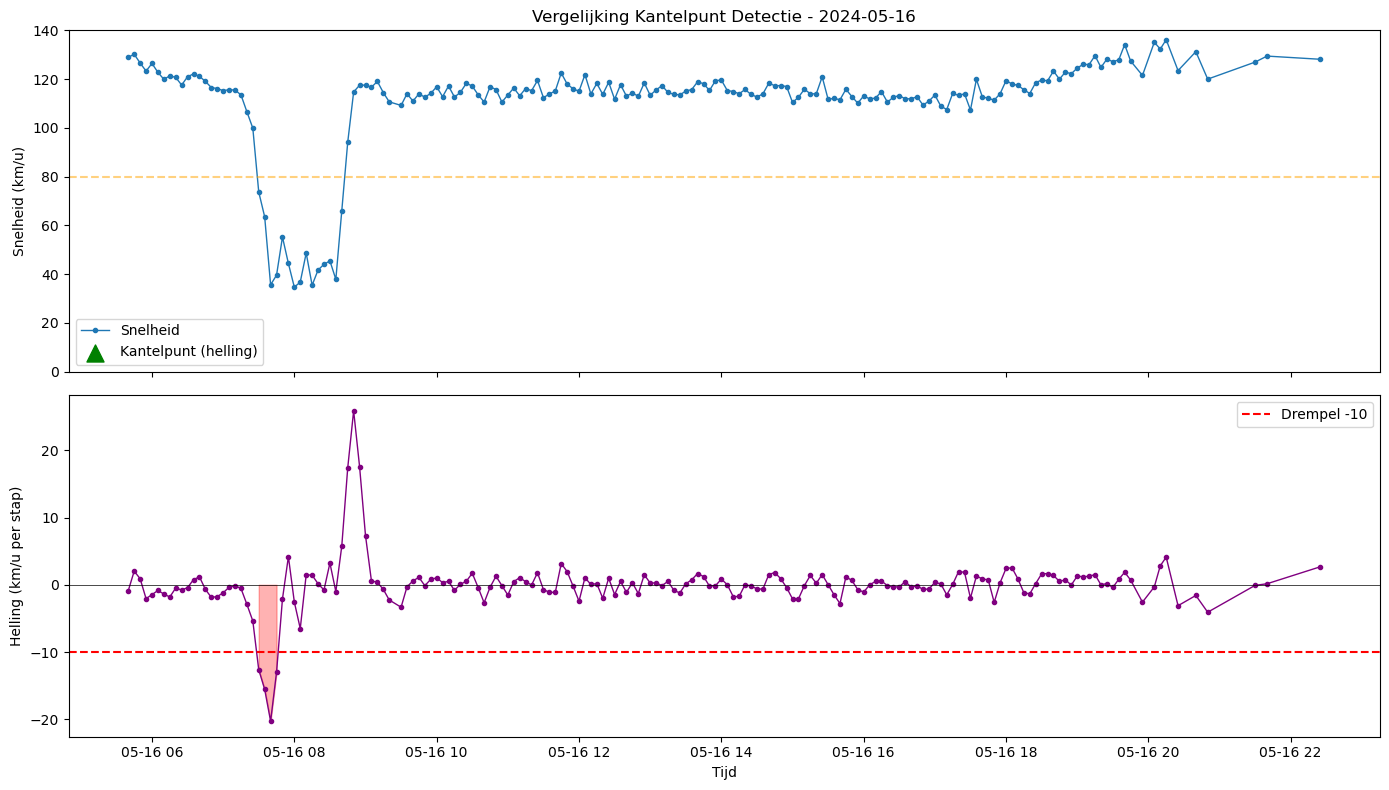

In [19]:
# Definieer kantelpunt op basis van helling
# Kantelpunt = sterke negatieve helling (-10) terwijl snelheid nog redelijk is (>80)

df_trend['kantelpunt_helling'] = (
    (df_trend['helling'] < -10) & 
    (df_trend['gem_snelheid'] > 80)
).astype(int)

print(f"Kantelpunten (helling < -10, snelheid > 80): {df_trend['kantelpunt_helling'].sum()}")

# Vergelijk met v3 definitie: hoeveel eerder detecteren we?
df_trend['datum'] = pd.to_datetime(df_trend['start_meetperiode']).dt.date

# Visualiseer op een congestie-dag
congestie_datum = pd.to_datetime('2024-05-16').date()
dag_data = df_trend[df_trend['datum'] == congestie_datum].sort_values('start_meetperiode')

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Snelheid met kantelpunten
ax1 = axes[0]
ax1.plot(dag_data['start_meetperiode'], dag_data['gem_snelheid'], 
         marker='o', markersize=3, linewidth=1, label='Snelheid')

# Kantelpunten helling-methode
kp_helling = dag_data[dag_data['kantelpunt_helling'] == 1]
ax1.scatter(kp_helling['start_meetperiode'], kp_helling['gem_snelheid'], 
            color='green', s=150, zorder=5, marker='^', label='Kantelpunt (helling)')

ax1.axhline(y=80, color='orange', linestyle='--', alpha=0.5)
ax1.set_ylabel('Snelheid (km/u)')
ax1.set_title(f'Vergelijking Kantelpunt Detectie - {congestie_datum}')
ax1.legend()
ax1.set_ylim(0, 140)

# Helling
ax2 = axes[1]
ax2.plot(dag_data['start_meetperiode'], dag_data['helling'], 
         marker='o', markersize=3, linewidth=1, color='purple')
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axhline(y=-10, color='red', linestyle='--', label='Drempel -10')
ax2.fill_between(dag_data['start_meetperiode'], dag_data['helling'], 0, 
                  where=dag_data['helling'] < -10, alpha=0.3, color='red')
ax2.set_ylabel('Helling (km/u per stap)')
ax2.set_xlabel('Tijd')
ax2.legend()

plt.tight_layout()
plt.show()

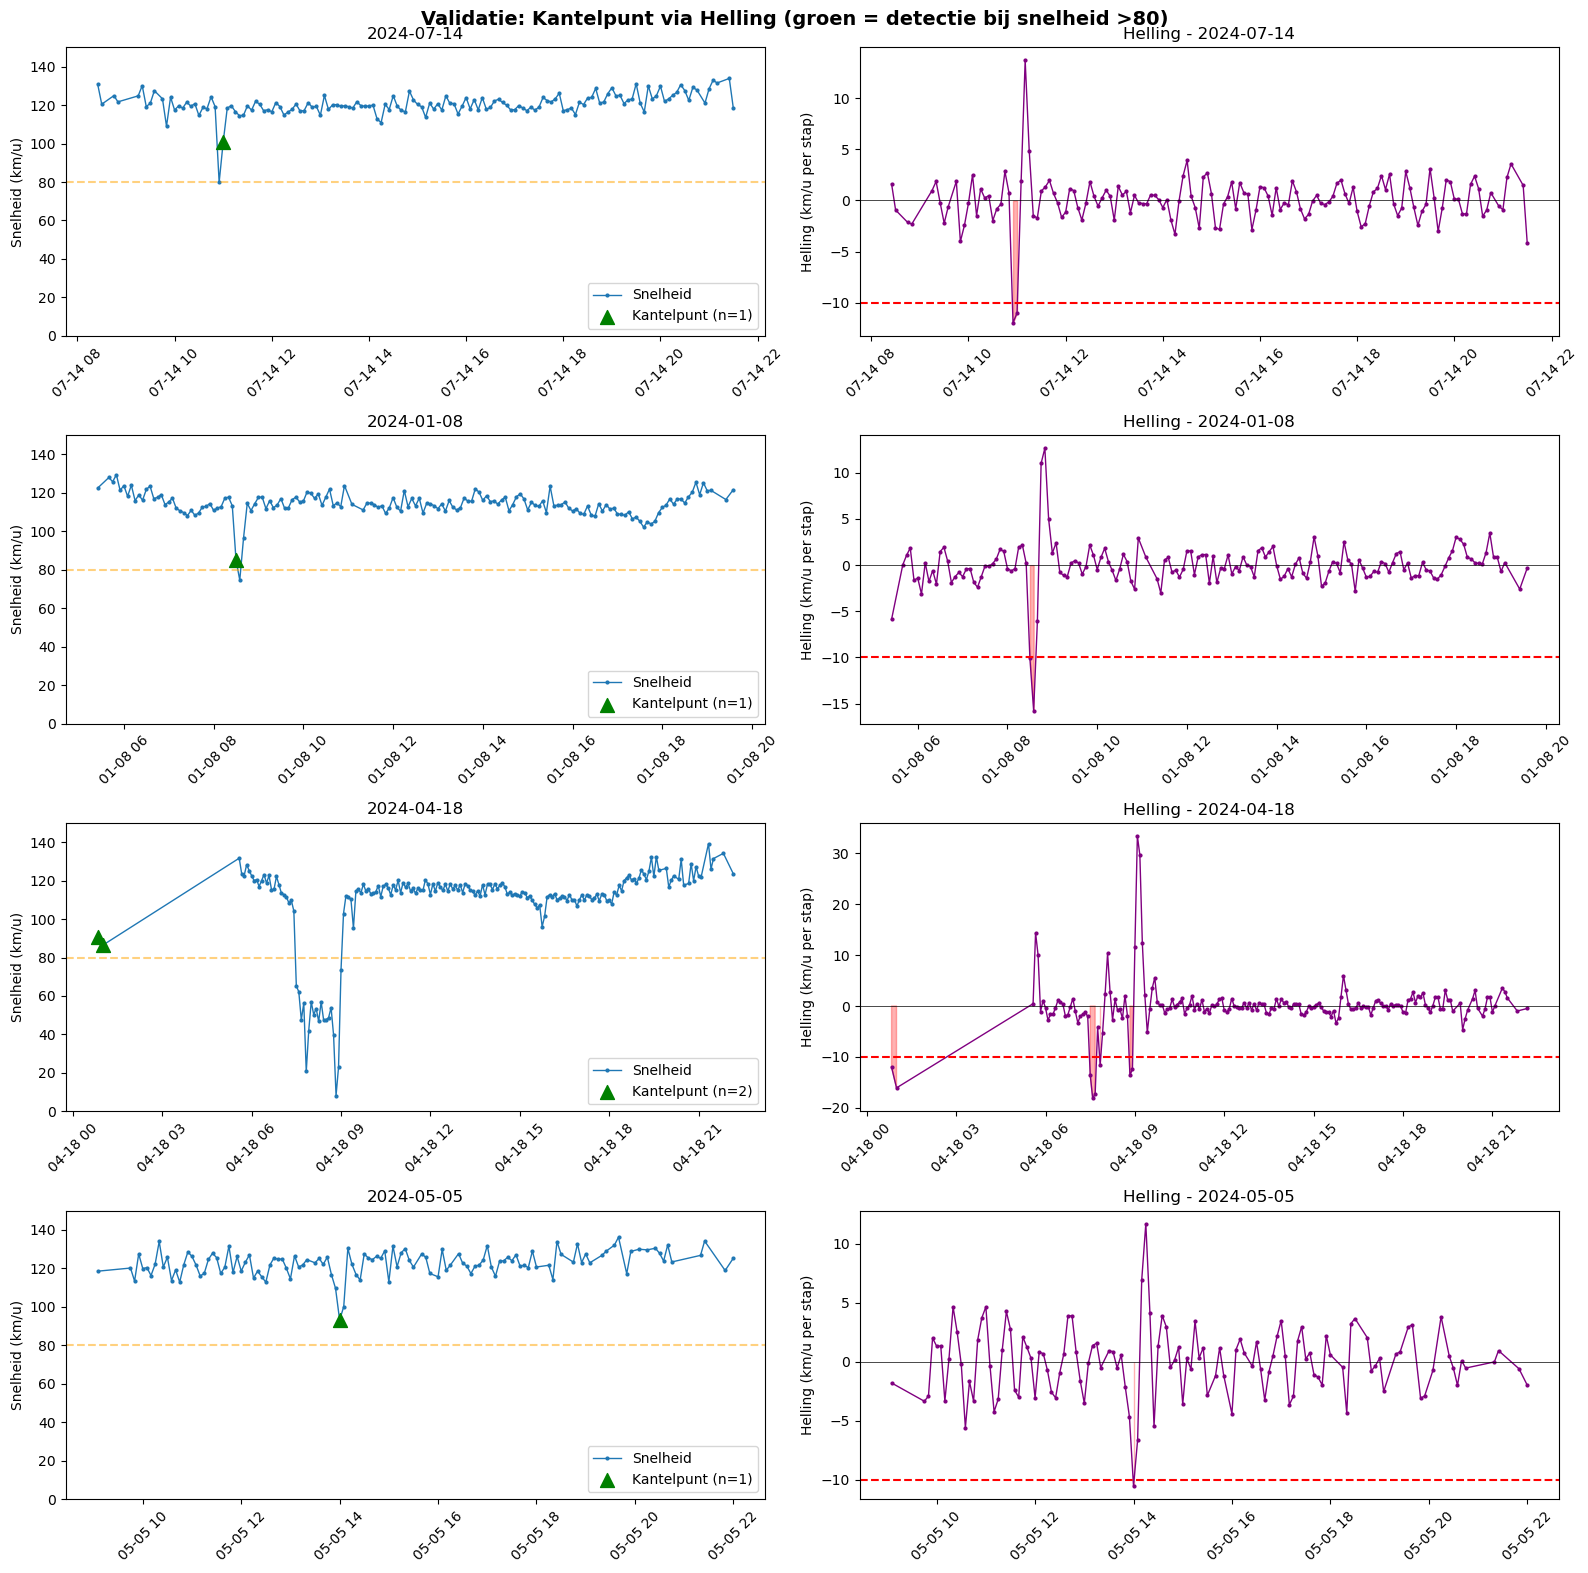

In [20]:
# Validatie helling-methode op 4 willekeurige congestie-dagen
dagen_met_kp = df_trend[df_trend['kantelpunt_helling'] == 1]['datum'].unique()
sample_dagen = np.random.choice(dagen_met_kp, size=min(4, len(dagen_met_kp)), replace=False)

fig, axes = plt.subplots(4, 2, figsize=(16, 16))

for idx, datum in enumerate(sample_dagen):
    dag_data = df_trend[df_trend['datum'] == datum].sort_values('start_meetperiode')
    
    # Linker kolom: Snelheid
    ax1 = axes[idx, 0]
    ax1.plot(dag_data['start_meetperiode'], dag_data['gem_snelheid'], 
             marker='o', markersize=2, linewidth=1, label='Snelheid')
    
    kp = dag_data[dag_data['kantelpunt_helling'] == 1]
    ax1.scatter(kp['start_meetperiode'], kp['gem_snelheid'], 
                color='green', s=100, zorder=5, marker='^', label=f'Kantelpunt (n={len(kp)})')
    
    ax1.axhline(y=80, color='orange', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Snelheid (km/u)')
    ax1.set_title(f'{datum}')
    ax1.legend(loc='lower right')
    ax1.set_ylim(0, 150)
    ax1.tick_params(axis='x', rotation=45)
    
    # Rechter kolom: Helling
    ax2 = axes[idx, 1]
    ax2.plot(dag_data['start_meetperiode'], dag_data['helling'], 
             marker='o', markersize=2, linewidth=1, color='purple')
    ax2.axhline(y=0, color='black', linewidth=0.5)
    ax2.axhline(y=-10, color='red', linestyle='--')
    ax2.fill_between(dag_data['start_meetperiode'], dag_data['helling'], 0, 
                      where=dag_data['helling'] < -10, alpha=0.3, color='red')
    ax2.set_ylabel('Helling (km/u per stap)')
    ax2.set_title(f'Helling - {datum}')
    ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Validatie: Kantelpunt via Helling (groen = detectie bij snelheid >80)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 

Het probleem met de huidige aanpak is dat we het kantelpunt detecteren **wanneer het gebeurt**. Voor voorspelling willen we weten: **gaat er binnen X stappen een kantelpunt komen?**

**Nieuwe aanpak:**
1. Gebruik `gem_snelheid_smooth` (Savitzky-Golay gefilterd) voor minder ruis
2. Definieer het kantelpunt moment
3. Maak een target: `kantelpunt_komend` = 1 als er binnen 3 stappen (15 min) een kantelpunt komt

Dit geeft ons een voorspellingswindow.

In [21]:
# Gebruik smoothed data en maak voorspellings-target
df_pred = df_locatie.sort_values('start_meetperiode').copy()

# Bereken helling op smoothed data
df_pred['helling_smooth'] = df_pred['gem_snelheid_smooth'].rolling(window=4).apply(
    lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 4 else np.nan, raw=False
)

# Detecteer kantelpunt: van >100 naar <70 in 3 stappen (op smoothed data)
df_pred['snelheid_3_terug'] = df_pred['gem_snelheid_smooth'].shift(3)
df_pred['kantelpunt'] = (
    (df_pred['snelheid_3_terug'] > 100) & 
    (df_pred['gem_snelheid_smooth'] < 70)
).astype(int)

# TARGET: Gaat er binnen 3 stappen een kantelpunt komen?
# Shift kantelpunt 3 stappen TERUG in de tijd
df_pred['target_kantelpunt_3'] = df_pred['kantelpunt'].shift(-3).fillna(0).astype(int)

# Of binnen 6 stappen (30 min)?
df_pred['target_kantelpunt_6'] = df_pred['kantelpunt'].rolling(window=6, min_periods=1).max().shift(-6).fillna(0).astype(int)

print(f"Kantelpunten (actueel): {df_pred['kantelpunt'].sum()}")
print(f"Target 3 stappen vooruit (15 min): {df_pred['target_kantelpunt_3'].sum()}")
print(f"Target 6 stappen vooruit (30 min): {df_pred['target_kantelpunt_6'].sum()}")

Kantelpunten (actueel): 61
Target 3 stappen vooruit (15 min): 61
Target 6 stappen vooruit (30 min): 286


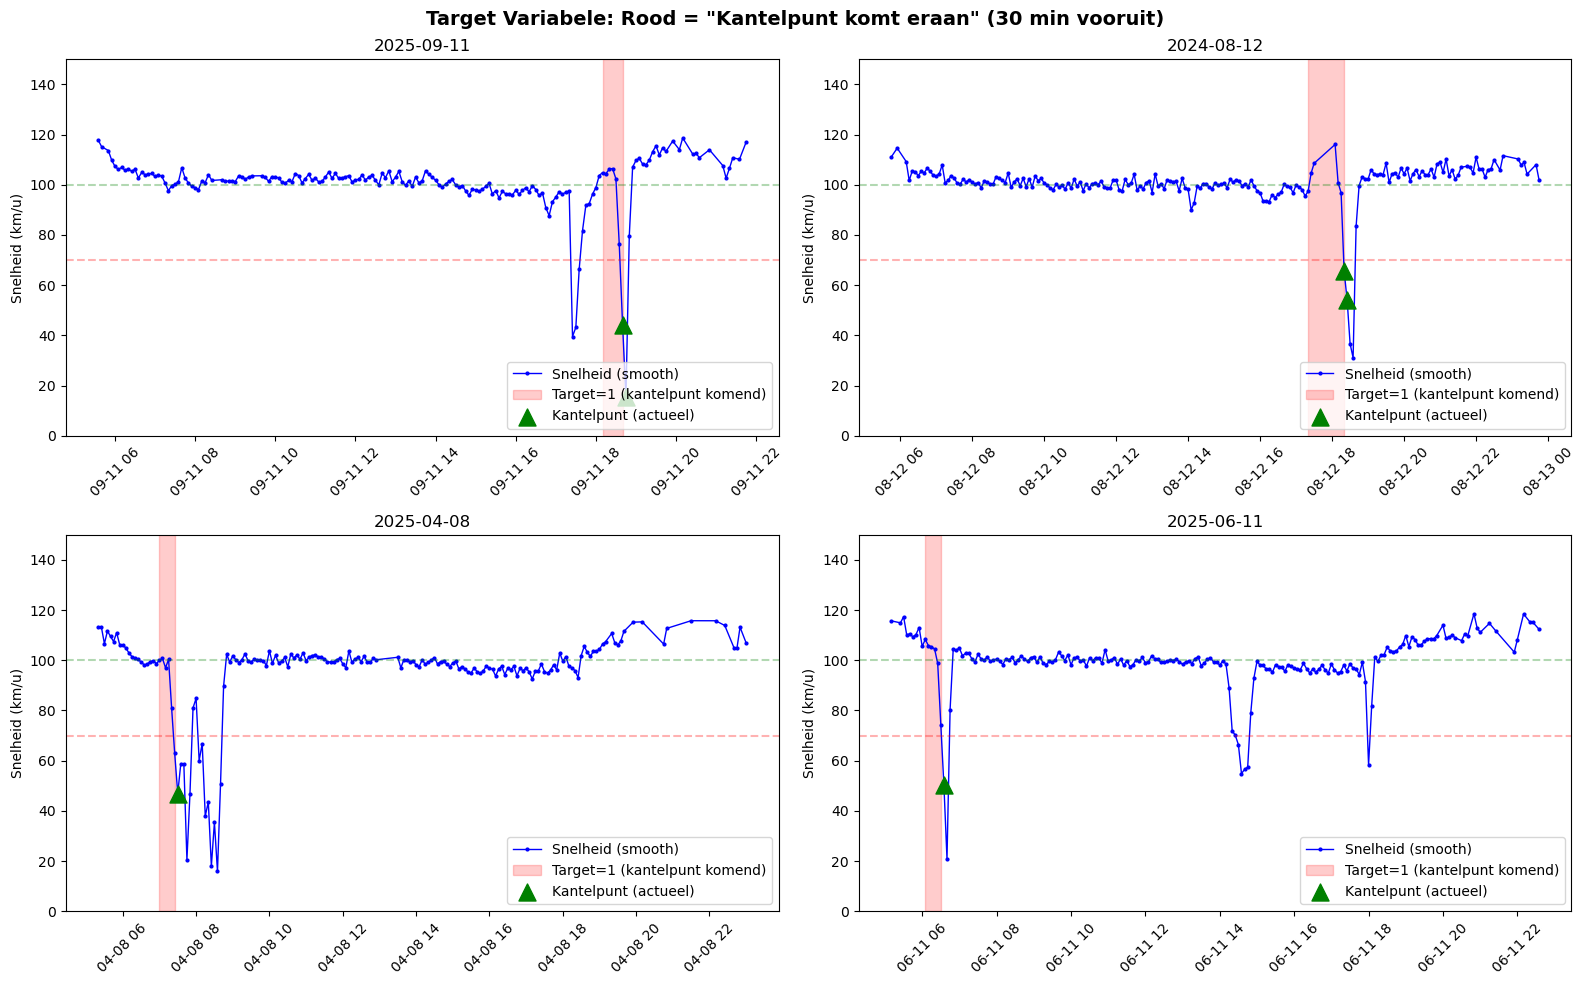

In [22]:
# Visualiseer target op congestie-dagen
df_pred['datum'] = pd.to_datetime(df_pred['start_meetperiode']).dt.date
dagen_met_kp = df_pred[df_pred['kantelpunt'] == 1]['datum'].unique()
sample_dagen = np.random.choice(dagen_met_kp, size=min(4, len(dagen_met_kp)), replace=False)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, datum in enumerate(sample_dagen):
    dag_data = df_pred[df_pred['datum'] == datum].sort_values('start_meetperiode')
    ax = axes[idx]
    
    # Snelheid (smoothed)
    ax.plot(dag_data['start_meetperiode'], dag_data['gem_snelheid_smooth'], 
            marker='o', markersize=2, linewidth=1, label='Snelheid (smooth)', color='blue')
    
    # Markeer target=1 momenten (voorspellingswindow)
    target_momenten = dag_data[dag_data['target_kantelpunt_6'] == 1]
    ax.fill_between(dag_data['start_meetperiode'], 0, 150, 
                     where=dag_data['target_kantelpunt_6'] == 1,
                     alpha=0.2, color='red', label='Target=1 (kantelpunt komend)')
    
    # Markeer daadwerkelijke kantelpunten
    kp = dag_data[dag_data['kantelpunt'] == 1]
    ax.scatter(kp['start_meetperiode'], kp['gem_snelheid_smooth'], 
               color='green', s=150, zorder=5, marker='^', label='Kantelpunt (actueel)')
    
    ax.axhline(y=100, color='green', linestyle='--', alpha=0.3)
    ax.axhline(y=70, color='red', linestyle='--', alpha=0.3)
    ax.set_ylabel('Snelheid (km/u)')
    ax.set_title(f'{datum}')
    ax.legend(loc='lower right')
    ax.set_ylim(0, 150)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Target Variabele: Rood = "Kantelpunt komt eraan" (30 min vooruit)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


| AC | Vraag | Antwoord |
|----|-------|----------|
| 1 | Definitie kantelpunt | Snelheid daalt van >100 naar <70 km/u binnen 3 stappen (15 min) |
| 2 | Hoeveel stappen daling? | 3 tijdstappen (15 minuten) |
| 3 | Met hoeveel km/u daling? | Minimaal 30 km/u (van >100 naar <70) |


We zoeken de beste combinatie van:
1. **Bovengrens:** Snelheid waarboven "normaal" is (90, 100, 110 km/u)
2. **Ondergrens:** Snelheid waaronder "congestie" is (50, 60, 70, 80 km/u)
3. **Aantal stappen:** Tijdsperiode voor de daling (2, 3, 4, 5 stappen)

We evalueren op basis van:
- Aantal gedetecteerde kantelpunten
- Aantal dagen met kantelpunt
- Minimale daling (verschil boven- en ondergrens)

In [23]:
# Gridsearch: alleen daling over tijdstappen
from itertools import product

def test_daling_definitie(df, n_stappen, min_daling, snelheid_col='gem_snelheid_smooth'):
    """Test kantelpunt op basis van daling over n stappen."""
    df = df.sort_values('start_meetperiode').copy()
    df['datum'] = pd.to_datetime(df['start_meetperiode']).dt.date
    
    # Daling over n stappen
    df['daling'] = df[snelheid_col].shift(n_stappen) - df[snelheid_col]
    
    # Kantelpunt = daling groter dan drempel
    df['kantelpunt'] = (df['daling'] > min_daling).astype(int)
    
    n_kantelpunten = df['kantelpunt'].sum()
    n_dagen = df.groupby('datum')['kantelpunt'].max().sum()
    
    return n_kantelpunten, n_dagen

# Parameters
stappen_opties = [2, 3, 4, 5, 6]
daling_opties = [20, 25, 30, 35, 40, 45, 50, 60]

# Gridsearch
resultaten = []

for n_stap, min_dal in product(stappen_opties, daling_opties):
    n_kp, n_dagen = test_daling_definitie(df_locatie, n_stap, min_dal)
    
    resultaten.append({
        'stappen': n_stap,
        'tijdsperiode': f"{n_stap * 5} min",
        'min_daling_km/u': min_dal,
        'kantelpunten': n_kp,
        'dagen': n_dagen
    })

df_grid = pd.DataFrame(resultaten)

print("=== GRIDSEARCH: DALING OVER TIJDSTAPPEN ===\n")
print(f"Totaal combinaties: {len(df_grid)}")
print(f"Totaal dagen in dataset: {df_locatie['datum'].nunique()}")
print(f"\nAlle resultaten:\n")
print(df_grid.to_string(index=False))

=== GRIDSEARCH: DALING OVER TIJDSTAPPEN ===

Totaal combinaties: 40
Totaal dagen in dataset: 699

Alle resultaten:

 stappen tijdsperiode  min_daling_km/u  kantelpunten  dagen
       2       10 min               20           581    177
       2       10 min               25           475    159
       2       10 min               30           380    140
       2       10 min               35           295    123
       2       10 min               40           243    110
       2       10 min               45           189     95
       2       10 min               50           142     78
       2       10 min               60            81     58
       3       15 min               20           752    178
       3       15 min               25           617    160
       3       15 min               30           521    148
       3       15 min               35           424    139
       3       15 min               40           355    128
       3       15 min               45      


**File definitie:**
- Snelheid < 50 km/u gedurende **2 opeenvolgende tijdstappen** (10 minuten)
- Dit filtert korte dips eruit

**Kantelpunt definitie:**
- Daling over **4 tijdstappen** (20 minuten)
- We zoeken de optimale daling-drempel via gridsearch

In [24]:
# Verfijnde definitie: file = 2 stappen onder 50 km/u
def test_kantelpunt_met_file(df, min_daling, snelheid_col='gem_snelheid_smooth'):
    """
    Kantelpunt definitie:
    - File = snelheid < 50 km/u gedurende 2 opeenvolgende stappen
    - Kantelpunt = daling > min_daling over 4 stappen, gevolgd door file
    """
    df = df.sort_values('start_meetperiode').copy()
    df['datum'] = pd.to_datetime(df['start_meetperiode']).dt.date
    
    # File: 2 opeenvolgende stappen onder 50 km/u
    df['onder_50'] = df[snelheid_col] < 50
    df['file'] = df['onder_50'] & df['onder_50'].shift(1)
    
    # Daling over 4 stappen
    df['daling_4_stappen'] = df[snelheid_col].shift(4) - df[snelheid_col]
    
    # Kantelpunt: grote daling EN file
    df['kantelpunt'] = (
        (df['daling_4_stappen'] > min_daling) & 
        df['file']
    ).astype(int)
    
    n_kantelpunten = df['kantelpunt'].sum()
    n_dagen = df.groupby('datum')['kantelpunt'].max().sum()
    n_file_momenten = df['file'].sum()
    
    return n_kantelpunten, n_dagen, n_file_momenten

# Gridsearch voor minimale daling
daling_opties = [20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80]

resultaten = []
for min_dal in daling_opties:
    n_kp, n_dagen, n_file = test_kantelpunt_met_file(df_locatie, min_dal)
    
    resultaten.append({
        'min_daling_km/u': min_dal,
        'kantelpunten': n_kp,
        'dagen_met_kp': n_dagen,
        'file_momenten': n_file
    })

df_grid = pd.DataFrame(resultaten)

print(f"File definitie: snelheid < 50 km/u gedurende 2 stappen (10 min)\n")
print(f"Totaal dagen in dataset: {df_locatie['datum'].nunique()}")
print(f"\nResultaten:\n")
print(df_grid.to_string(index=False))

File definitie: snelheid < 50 km/u gedurende 2 stappen (10 min)

Totaal dagen in dataset: 699

Resultaten:

 min_daling_km/u  kantelpunten  dagen_met_kp  file_momenten
              20           319           103            622
              25           286           102            622
              30           259           100            622
              35           244            96            622
              40           230            94            622
              45           206            90            622
              50           182            81            622
              55           156            74            622
              60           135            72            622
              70            93            53            622
              80            59            33            622


## Grid search

om te kijken wat nu oprecht de beste manier is om te bepalen wat een goede definitie is. 

In [26]:
import pandas as pd
from itertools import product

def f_beta(precision, recall, beta=2):
    """Bereken F-beta score (beta > 1 = recall belangrijker)."""
    if precision + recall == 0:
        return 0
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

def test_daling_events(df, n_stappen, min_daling, snelheid_col='gem_snelheid_smooth'):
    """Event-based evaluatie: file-blokken vs voorspelde kantelpunten."""
    df = df.sort_values('start_meetperiode').copy()
    df['datum'] = pd.to_datetime(df['start_meetperiode']).dt.date
    
    # Kantelpunten
    df['daling'] = df[snelheid_col].shift(n_stappen) - df[snelheid_col]
    df['kantelpunt'] = (df['daling'] > min_daling).astype(int)
    
    # File-conditie per punt
    df['onder50'] = (df[snelheid_col] < 50).astype(int)
    
    # File-blokken detecteren (run-length encoding)
    df['file_block'] = (df['onder50'] != df['onder50'].shift()).cumsum()
    blocks = df.groupby('file_block')['onder50'].max()
    
    # Alleen blokken waar onder50 == 1 zijn echte files
    echte_files = blocks[blocks == 1].index
    
    TP, FN = 0, 0
    for block in echte_files:
        subset = df[df['file_block'] == block]
        if subset['kantelpunt'].sum() > 0:
            TP += 1   # er is minstens één kantelpunt in dit file-event
        else:
            FN += 1   # geen kantelpunt in dit file-event
    
    # False Positives = kantelpunten buiten file-blokken
    FP = df.loc[~df['file_block'].isin(echte_files), 'kantelpunt'].sum()
    
    # TN = aantal blokken zonder file én zonder kantelpunt
    geen_files = blocks[blocks == 0].index
    TN = 0
    for block in geen_files:
        subset = df[df['file_block'] == block]
        if subset['kantelpunt'].sum() == 0:
            TN += 1
    
    # Totalen
    totaal_kantelpunten = TP + FP
    totaal_echte_files  = TP + FN
    totaal_events       = TP + FP + FN + TN
    
    # Metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    f2        = f_beta(precision, recall, beta=2)  # recall krijgt meer gewicht
    
    return TP, FP, FN, TN, totaal_kantelpunten, totaal_echte_files, totaal_events, precision, recall, f1, f2

# Gridsearch
resultaten = []
for n_stap, min_dal in product([2,3,4,5,6, 7, 8, 9, 10], [20,25,30,35,40,45,50,60, 70]):
    TP, FP, FN, TN, totaal_kp, totaal_files, totaal_events, precision, recall, f1, f2 = test_daling_events(df_locatie, n_stap, min_dal)
    
    resultaten.append({
        'stappen': n_stap,
        'tijdsperiode': f"{n_stap * 5} min",
        'min_daling_km/u': min_dal,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'totaal_kantelpunten': totaal_kp,
        'totaal_echte_files': totaal_files,
        'totaal_events': totaal_events,
        'precision': round(precision, 3),
        'recall': round(recall, 3),
        'f1_score': round(f1, 3),
        'f2_score': round(f2, 3)   # recall-voorkeur
    })

df_grid = pd.DataFrame(resultaten)

print("=== GRIDSEARCH OP EVENT-NIVEAU MET F2-SCORE ===\n")
print(df_grid.to_string(index=False))

beste_f1 = df_grid.loc[df_grid['f1_score'].idxmax()]
beste_f2 = df_grid.loc[df_grid['f2_score'].idxmax()]

print("\n=== BESTE METHODE OP BASIS VAN F1-SCORE ===")
print(beste_f1.to_string())

print("\n=== BESTE METHODE OP BASIS VAN F2-SCORE (RECALL-VOORKEUR) ===")
print(beste_f2.to_string())

# Confusion matrix van de beste methode (F2)
print("\n=== CONFUSION MATRIX VAN BESTE METHODE (F2) ===")
print(pd.DataFrame({
    'Voorspeld File': [beste_f2['TP'], beste_f2['FP']],
    'Voorspeld Geen File': [beste_f2['FN'], beste_f2['TN']]
}, index=['Echte File', 'Echte Geen File']))

=== GRIDSEARCH OP EVENT-NIVEAU MET F2-SCORE ===

 stappen tijdsperiode  min_daling_km/u  TP  FP  FN  TN  totaal_kantelpunten  totaal_echte_files  totaal_events  precision  recall  f1_score  f2_score
       2       10 min               20 176 261  43  93                  437                 219            573      0.403   0.804     0.537     0.670
       2       10 min               25 163 191  56 111                  354                 219            521      0.460   0.744     0.569     0.663
       2       10 min               30 155 126  64 139                  281                 219            484      0.552   0.708     0.620     0.670
       2       10 min               35 142  70  77 162                  212                 219            451      0.670   0.648     0.659     0.653
       2       10 min               40 130  40  89 184                  170                 219            443      0.765   0.594     0.668     0.621
       2       10 min               45 119  15 100 

Uit deze evaluatiemethodes hebben we gekozen voor de recall-voorkeur. Dit is omdat de voorkeur ligt op het zoveel mogelijk voorkomen van files. Vanuit deze casus is het erger om een vertraging te 'negeren', doordat deze nooit is voorspeld, dan maatregelen te nemen in een situatie die al geen vertraging had opgeleverd.

Hieruit is te concluderen dat het "beste" cutoff point op basis van de hoogste recall score is:

- 40 min tijd
- min daling van 45km/h

dit is de definitie waar verder mee gewerkt gaat worden